# BERT Multi-lingual Model

### This notebook contains the implementation of the BERT model pre-trained on multiple languages coming from `Datasets/BERT/train_all_languages.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [ ]:
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import tensorflow
import gc
import sklearn.metrics

keras.mixed_precision.set_global_policy("mixed_float16")

label_names = ["entailment", "neutral", "contradiction"]


#### Data Exploration and Visualization

In [ ]:
bert_ML_dataset = pandas.read_csv("train_all_languages.csv")
bert_ML_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,f4891fa23f,Кто? Она спросила его с неожиданным интересом.,"Она спросила, как это сделать, так как с её то...",ru,Russian,1,neutral
1,1,e8b38c6175,Others are Zao (in Tohoku) and a number of res...,There are a lot of resorts in the national park.,en,English,0,entailment
2,2,e0a29d673a,trying to keep grass alive during a summer on ...,There was no cost in keeping the grass alive i...,en,English,2,contradiction
3,3,26222ec767,so i guess my experience is is just with what ...,They were able to be home rather than having t...,en,English,0,entailment
4,4,d0cf40f417,The Journal put the point succinctly to Is an...,"The Journal asked ""Is this a good political mo...",en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [ ]:
bert_ML_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [ ]:
bert_ML_dataset.label[~bert_ML_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [ ]:
bert_ML_dataset.id.count()

6060

- A fairly small dataset relatively speaking to other sources. Is bigger than the english set which does add some complexity.

In [ ]:
bert_ML_dataset.hypothesis.describe()

,hypothesis
count,6060
unique,6060
top,The canal is smaller than people expect it to be
freq,1


In [ ]:
for i in range(10):
    print(bert_ML_dataset.hypothesis[i])

Она спросила, как это сделать, так как с её точки зрения это казалось невозможным.
There are a lot of resorts in the national park.
There was no cost in keeping the grass alive in the summer time.
They were able to be home rather than having to worry about getting child care.
The Journal asked "Is this a good political move?"
Nhà phân tích đã không rõ ràng về nhiều thứ.
Η φωνή της έδειξε την ανησυχία της.
Those games are a lot of fun.
สมาชิกวงใน ไม่ได้รับอะไรเลย ในฐานะที่เป็นสมาชิกของกลุ่ม
White House murder mystery has other works before this one.


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion. In this set in particular multiple languages are being used to add nuance.

In [ ]:
bert_ML_dataset.premise.describe()

,premise
count,6060
unique,4970
top,Escaped or abandoned raccoons have been breedi...
freq,3


In [ ]:
for i in range(10):
    print(bert_ML_dataset.premise[i])

Кто? Она спросила его с неожиданным интересом.
Others are Zao (in Tohoku) and a number of resorts in Joshin-etsu Kogen National Park in the Japan Alps, where there are now splendid facilities thanks to the 1998 Winter Olympic Games in Nagano.
trying to keep grass alive during a summer on a piece of ground that big was expensive
so i guess my experience is is just with what we did and and so they didn't really go through the child care route they were able to be home together
The Journal put the point succinctly to  Is any publicity good publicity?
Tuy nhiên, email của nhà phân tích phản ánh rằng cô đang bối rối một loạt các rào cản và rào cản pháp lý đối với việc chia sẻ thông tin và các quy tắc điều chỉnh việc sử dụng thông tin của các nhân viên tội phạm thu thập thông qua các kênh tình báo.
Ω, παρακαλώ. Υπήρξε πραγματική ανησυχία στη φωνή της.
yeah okay yeah those games are fun to watch you you you watch those games
ในฐานะสมาชิกของอินเนอร์เซอร์เคิลคุณจะได้รับสิทธิเลือกที่นั่งในช่วงกา

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [ ]:
bert_ML_dataset.label.describe()

,label
count,6060.000000
mean,0.984653
std,0.821559
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

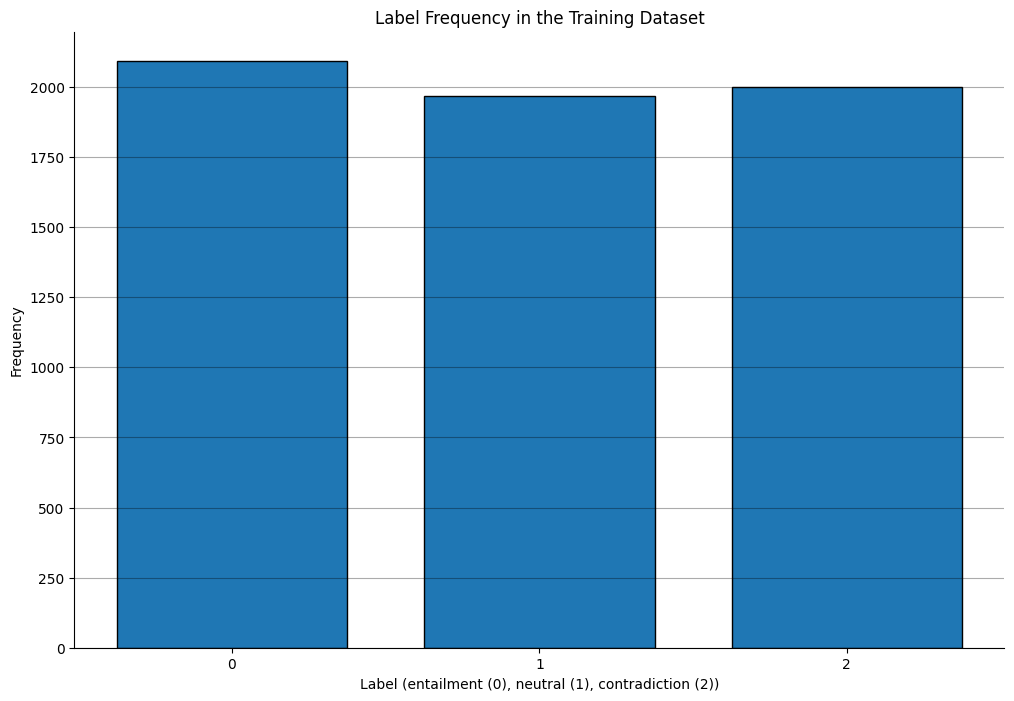

In [ ]:
labels = bert_ML_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [ ]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = bert_ML_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = bert_ML_dataset.premise.apply(get_length_of_text)

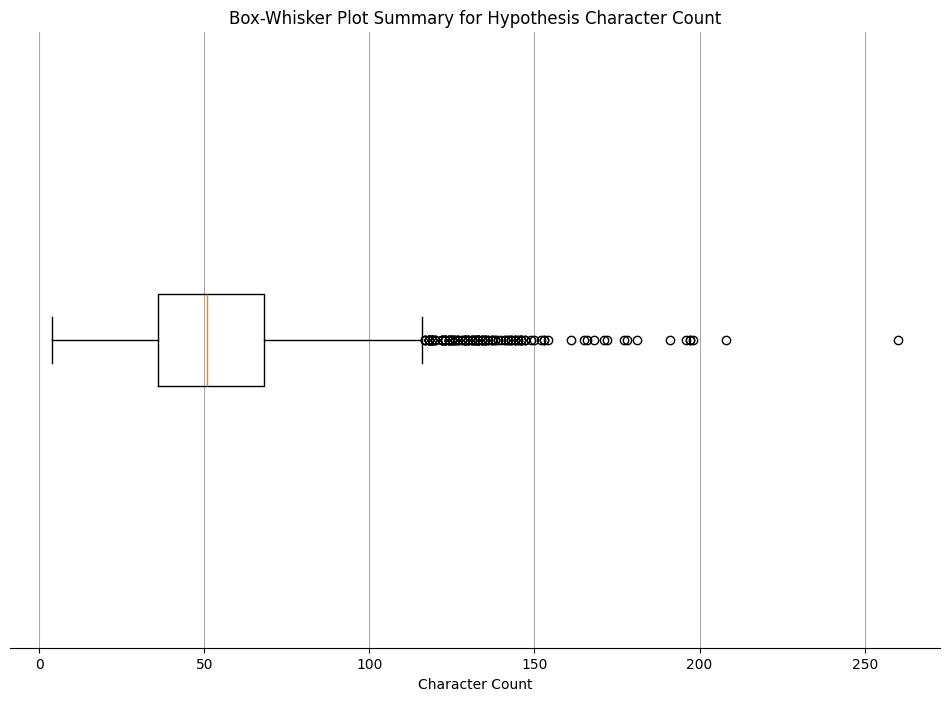

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

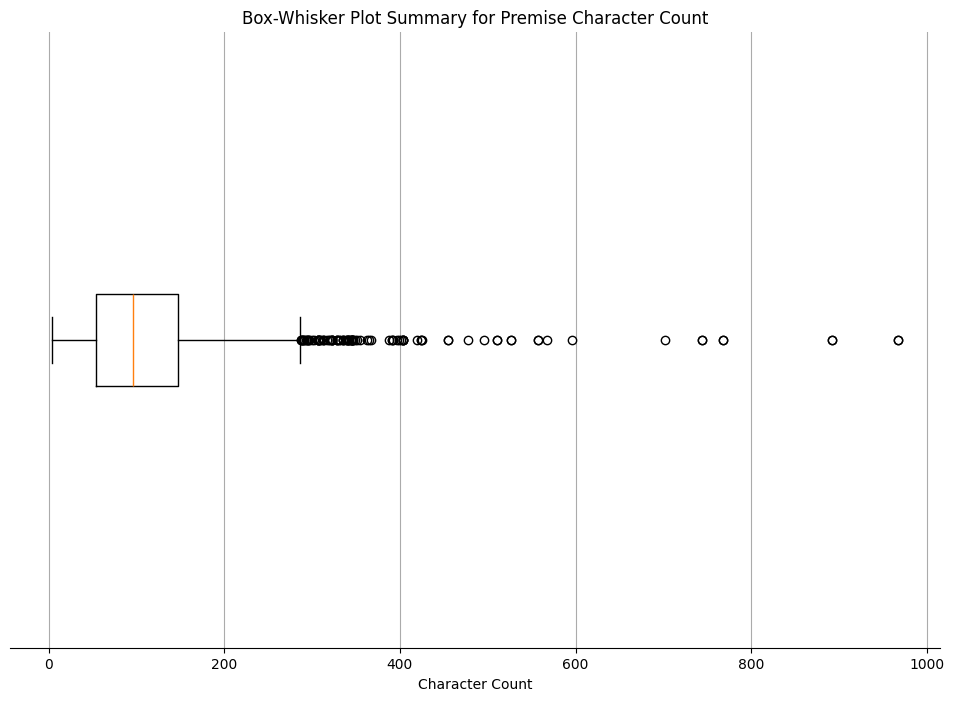

In [ ]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [ ]:
def split_labels(x, y):
    return (x[0], x[1]), y

In [ ]:
def process_labels_and_predictions(datalist, logits):
    predictions = tensorflow.argmax(tensorflow.nn.softmax(logits, 1), 1).numpy()

    first_label_set_processed = False

    labels = None

    for i in range(len(datalist)):
        if not first_label_set_processed:
            labels = datalist[i][1].numpy()

            first_label_set_processed = True
        else:
            labels = numpy.hstack((labels, datalist[i][1].numpy()))

    return labels, predictions

In [ ]:
def plot_metrics():
  validation_logits = classifier.predict(bert_val_set)
  validation_set_list = list(bert_val_set)
  labels, predictions = process_labels_and_predictions(validation_set_list, validation_logits)
  print(sklearn.metrics.classification_report(labels, predictions, target_names=label_names))

  matrix = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(labels, predictions), display_labels=label_names)
  matrix.plot()
  plt.show()

In [ ]:
batch_size = 32
buffer_size = batch_size * 10

VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(bert_ML_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            bert_ML_dataset[["hypothesis", "premise"]].values,
            bert_ML_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

print(f"Size of the train dataset: {TRAIN_SIZE}")
print(f"Size of the validation dataset: {len(val_dataset)}")

train_preprocessed = train_dataset.shuffle(buffer_size=buffer_size).map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

Size of the train dataset: 4848
Size of the validation dataset: 1212


In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_multi", sequence_length=512)

def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)

max_token_length = get_max_token_length(bert_ML_dataset, preprocessor)

print(f"Maximum token length in the dataset: {max_token_length}")

100%|██████████| 511/511 [00:00<00:00, 1.09MB/s]


100%|██████████| 548/548 [00:00<00:00, 1.04MB/s]


100%|██████████| 972k/972k [00:00<00:00, 2.81MB/s]


Maximum token length in the dataset: 260


In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_multi", sequence_length=265)

bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", preprocessor=None, num_classes=3)
history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=3)

100%|██████████| 679M/679M [00:14<00:00, 50.1MB/s]


Epoch 1/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 176s 572ms/step - loss: 1.0695 - sparse_categorical_accuracy: 0.4191 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.5591
Epoch 2/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 78s 517ms/step - loss: 0.8948 - sparse_categorical_accuracy: 0.5954 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.5752
Epoch 3/3
151/151 ━━━━━━━━━━━━━━━━━━━━ 77s 511ms/step - loss: 0.7684 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.9639 - val_sparse_categorical_accuracy: 0.6039


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step
               precision    recall  f1-score   support

   entailment       0.70      0.52      0.59       400
      neutral       0.54      0.76      0.64       404
contradiction       0.62      0.53      0.57       380

     accuracy                           0.60      1184
    macro avg       0.62      0.60      0.60      1184
 weighted avg       0.62      0.60      0.60      1184



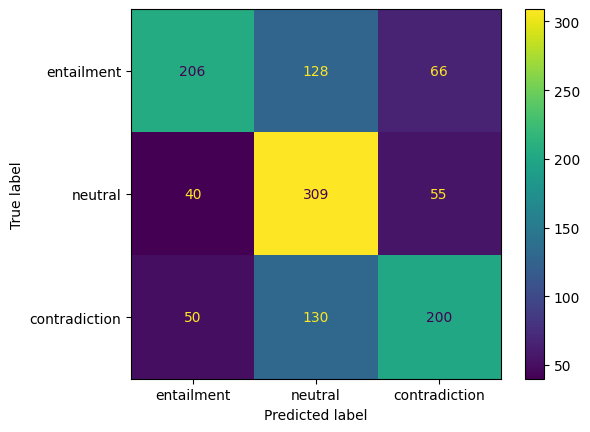

None


In [ ]:
print(plot_metrics())

#### Save the Model

In [ ]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
classifier.save_weights("BERT_Multi_test_1.weights.h5")

### Load model weights

In [ ]:
classifier.load_weights("BERT_Multi_test_1.weights.h5")

- Testing potential memory managing techniques

In [ ]:
del classifier
gc.collect()
keras.backend.clear_session()

- Bringing callback method from bert en notebook

In [ ]:
class BCP(keras.callbacks.Callback):
    batch_accuracy = []
    batch_loss = []
    def __init__(self):
        super(BCP,self).__init__()
    def on_train_batch_end(self, batch, logs=None):
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_loss.append(logs.get('loss'))

### Training loops and hyperparameter random searching

- Single instance test to ensure proper compiling

Epoch 1/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 177s 311ms/step - accuracy: 0.4001 - loss: 1.0751 - val_accuracy: 0.5608 - val_loss: 0.9284
Epoch 2/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.6173 - loss: 0.8511 - val_accuracy: 0.5950 - val_loss: 0.9116
Epoch 3/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.7570 - loss: 0.6115 - val_accuracy: 0.6117 - val_loss: 1.0210
Epoch 4/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.8442 - loss: 0.4152 - val_accuracy: 0.5983 - val_loss: 1.1246
Epoch 5/5
303/303 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.9062 - loss: 0.2774 - val_accuracy: 0.6033 - val_loss: 1.2182


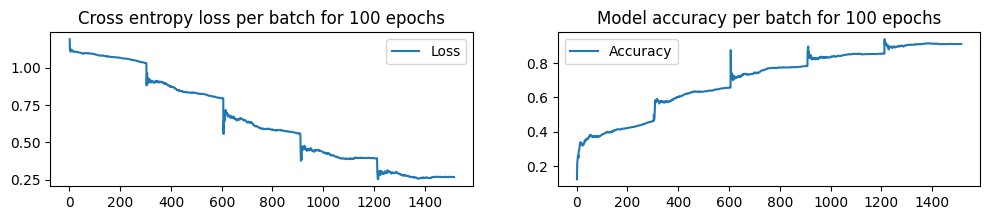

In [ ]:
batch_size = 16
buffer_size = batch_size * 10

train_preprocessed = train_dataset.shuffle(buffer_size=buffer_size).map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_multi", sequence_length=265)

bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", preprocessor=None, num_classes=3)

classifier.compile(optimizer=keras.optimizers.Adam(1e-5), metrics=['accuracy'])
callback = BCP()
BCP.batch_accuracy = []
BCP.batch_loss = []
history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback]);

figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
ax1.plot(numpy.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
ax1.set_title("Cross entropy loss per batch for 100 epochs")
ax1.legend()
ax2.plot(numpy.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
ax2.set_title("Model accuracy per batch for 100 epochs")
ax2.legend()

del classifier, train_preprocessed, val_preprocessed, bert_train_set, bert_val_set, preprocessor
gc.collect()
keras.backend.clear_session()

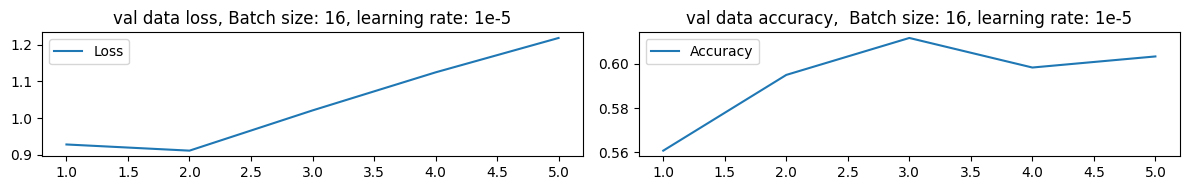

In [ ]:
history_dict = history.history
loss = history_dict["val_loss"]
acc = history_dict["val_accuracy"]
figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
ax1.plot(numpy.arange(1,len(loss)+1), loss, label="Loss")
ax1.set_title("val data loss, Batch size: 16, learning rate: 1e-5")
ax1.legend()
ax2.plot(numpy.arange(1,len(acc)+1), acc, label="Accuracy")
ax2.set_title("val data accuracy,  Batch size: 16, learning rate: 1e-5")
ax2.legend()
figure.tight_layout()

- Random search implementation

Epoch 1/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 148s 266ms/step - accuracy: 0.3232 - loss: 1.9804 - val_accuracy: 0.3176 - val_loss: 1.7167
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 65s 241ms/step - accuracy: 0.3207 - loss: 1.6095 - val_accuracy: 0.3176 - val_loss: 1.5555
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 65s 241ms/step - accuracy: 0.3229 - loss: 1.5620 - val_accuracy: 0.3176 - val_loss: 1.6159
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 65s 241ms/step - accuracy: 0.3216 - loss: 1.6080 - val_accuracy: 0.3176 - val_loss: 1.4001
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 65s 241ms/step - accuracy: 0.3218 - loss: 1.6533 - val_accuracy: 0.3176 - val_loss: 1.7091
Epoch 1/5
538/538 ━━━━━━━━━━━━━━━━━━━━ 161s 134ms/step - accuracy: 0.3457 - loss: 1.1994 - val_accuracy: 0.3176 - val_loss: 1.2182
Epoch 2/5
538/538 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.3275 - loss: 1.1678 - val_accuracy: 0.3176 - val_loss: 1.1776
Epoch 3/5
538/538 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.3365 - loss: 1.1465 

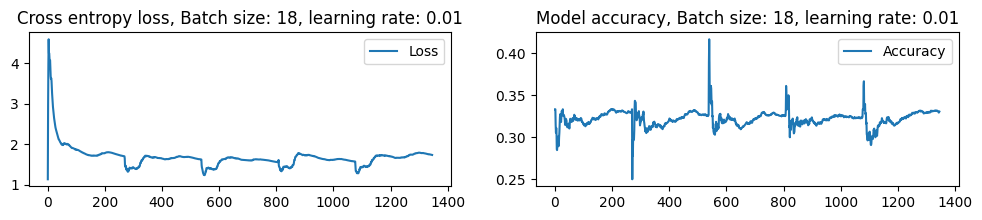

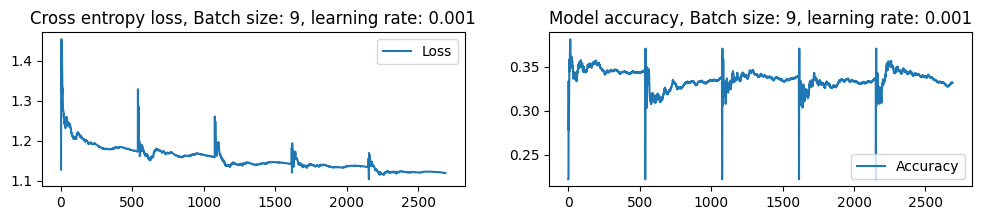

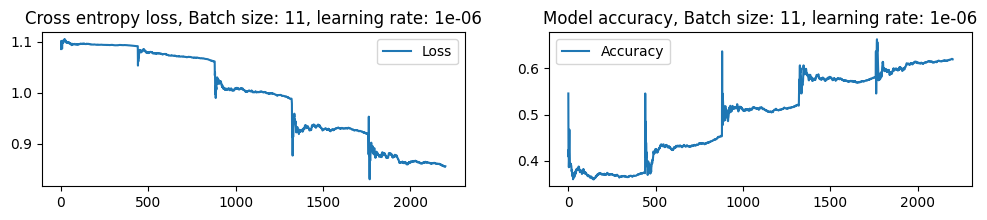

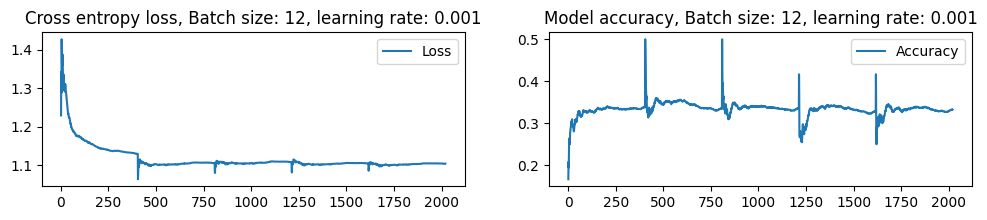

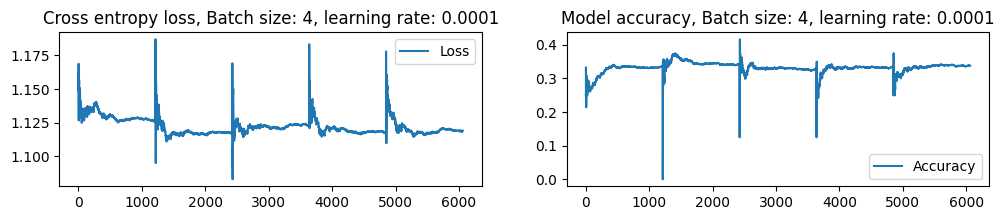

In [ ]:
histories = []
batches_used = []
learning_rates_used = []
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_multi", sequence_length=195) #does not need to be reinitialized every loop
for i in range(5):
  batch_size = numpy.random.randint(4, 32)
  learning_rate = numpy.random.choice([0.01, 0.001, 0.0001, 0.00001, 0.000001])

  train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
  val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

  bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", preprocessor=None, num_classes=3)

  classifier.compile(optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

  callback = BCP()
  BCP.batch_accuracy = []
  BCP.batch_loss = []
  history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback])

  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(numpy.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
  ax1.set_title("Cross entropy loss, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax1.legend()
  ax2.plot(numpy.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
  ax2.set_title("Model accuracy, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax2.legend()
  batches_used.append(batch_size)
  learning_rates_used.append(learning_rate)
  histories.append(history)

  del classifier, train_preprocessed, val_preprocessed, bert_train_set, bert_val_set
  gc.collect()
  keras.backend.clear_session()

Best batch: 12
Best learning rate: 0.001
Accuracy: 0.5743801593780518


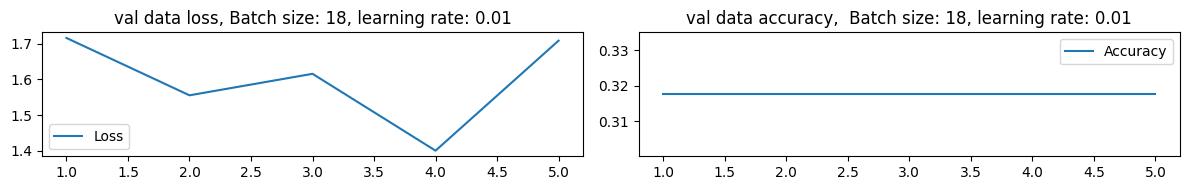

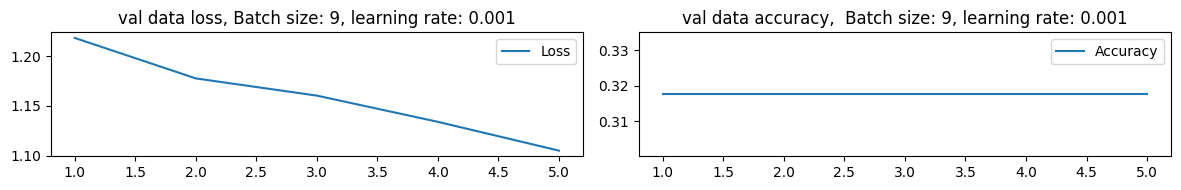

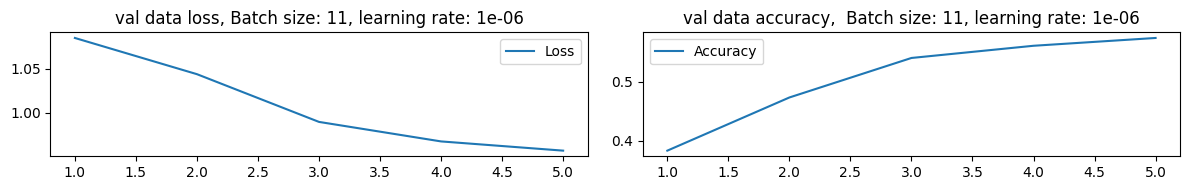

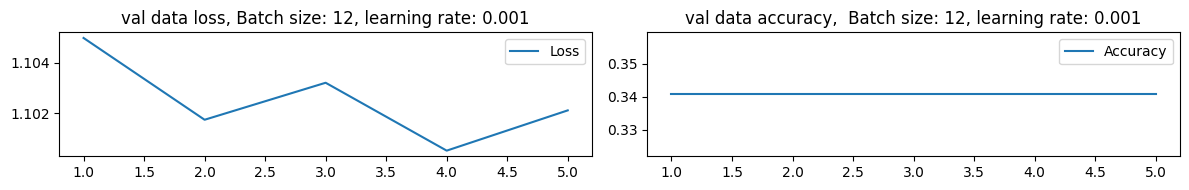

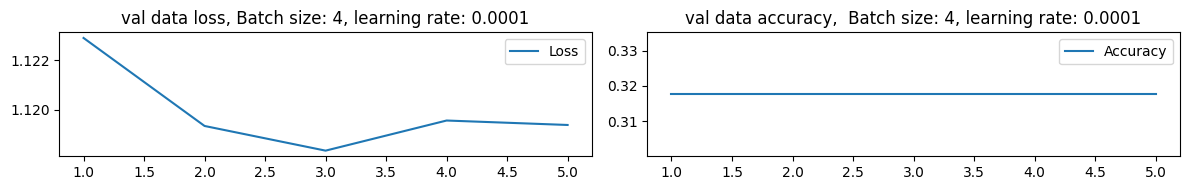

In [ ]:
index = 0
best_accuracy = 0
best_batch = 0
best_learning_rate = 0

for i in histories:
  history_dict = i.history
  loss = history_dict["val_loss"]
  acc = history_dict["val_accuracy"]
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(numpy.arange(1,len(loss)+1), loss, label="Loss")
  ax1.set_title("val data loss, Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax1.legend()
  ax2.plot(numpy.arange(1,len(acc)+1), acc, label="Accuracy")
  ax2.set_title("val data accuracy,  Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax2.legend()
  figure.tight_layout()
  index = index + 1
  if acc[-1] > best_accuracy:
    best_accuracy = acc[-1]
    best_batch = batches_used[index]
    best_learning_rate = learning_rates_used[index]

print("Best batch: "+str(best_batch))
print("Best learning rate: "+str(best_learning_rate))
print("Accuracy: "+str(best_accuracy))

0.01, 0.001, 0.0001 are too high learning rates

- Reutilizing lr ranges from bert EN as the tendencies with ML with lr seem to match it

Epoch 1/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 110s 107ms/step - accuracy: 0.3689 - loss: 1.0903 - val_accuracy: 0.5041 - val_loss: 0.9893
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.5734 - loss: 0.9212 - val_accuracy: 0.5862 - val_loss: 0.9011
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.6769 - loss: 0.7429 - val_accuracy: 0.6136 - val_loss: 0.9224
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7637 - loss: 0.5905 - val_accuracy: 0.6153 - val_loss: 0.9866
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.8080 - loss: 0.4833 - val_accuracy: 0.5962 - val_loss: 1.0753
Epoch 1/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 110s 91ms/step - accuracy: 0.3848 - loss: 1.0795 - val_accuracy: 0.5708 - val_loss: 0.9353
Epoch 2/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.6093 - loss: 0.8911 - val_accuracy: 0.6175 - val_loss: 0.8809
Epoch 3/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7120 - loss: 0.6890 - val_a

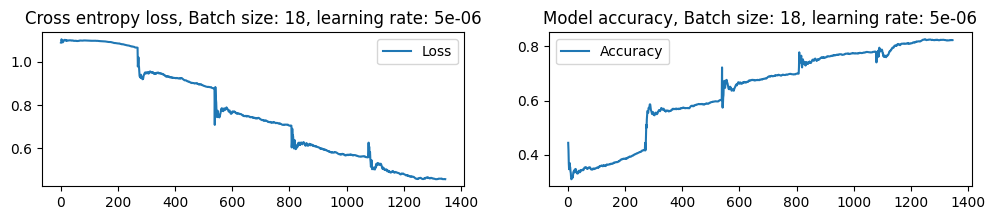

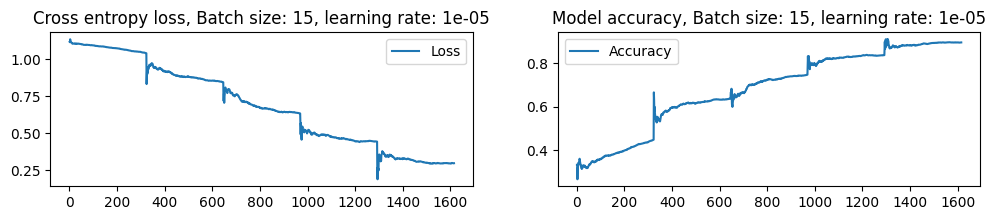

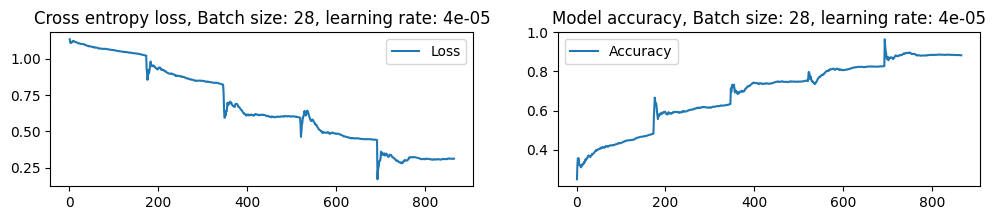

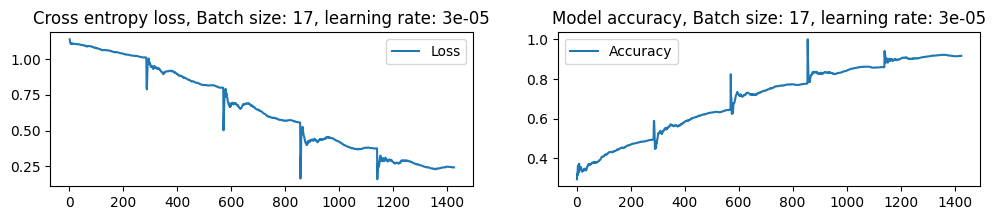

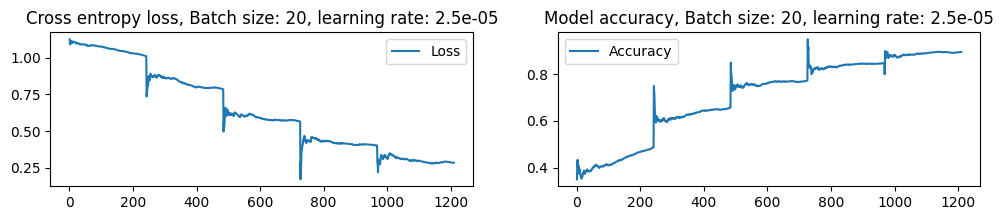

In [ ]:
histories = []
batches_used = []
learning_rates_used = []
models = []
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_base_multi", sequence_length=195) #does not need to be reinitialized every loop
for i in range(5):
  batch_size = numpy.random.randint(4, 32)
  buffer_size = batch_size * 10
  learning_rate = numpy.random.randint(1, 10)/200000

  train_preprocessed = train_dataset.shuffle(buffer_size=buffer_size).map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).prefetch(tensorflow.data.AUTOTUNE)
  val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

  bert_train_set = (train_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  bert_val_set = (val_preprocessed.map(preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE))

  classifier = keras_nlp.models.BertClassifier.from_preset("bert_base_multi", preprocessor=None, num_classes=3)

  classifier.compile(optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

  callback = BCP()
  BCP.batch_accuracy = []
  BCP.batch_loss = []
  history = classifier.fit(bert_train_set, validation_data=bert_val_set, epochs=5, callbacks=[callback])

  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(numpy.arange(1,len(callback.batch_loss)+1), BCP.batch_loss, label="Loss")
  ax1.set_title("Cross entropy loss, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax1.legend()
  ax2.plot(numpy.arange(1,len(BCP.batch_accuracy)+1), BCP.batch_accuracy, label="Accuracy")
  ax2.set_title("Model accuracy, Batch size: "+str(batch_size)+", learning rate: "+str(learning_rate))
  ax2.legend()
  batches_used.append(batch_size)
  learning_rates_used.append(learning_rate)
  histories.append(history)

  models.append(classifier)

  del classifier, train_preprocessed, val_preprocessed, bert_train_set, bert_val_set
  gc.collect()
  keras.backend.clear_session()

Best batch: 28
Best learning rate: 4e-05
Accuracy: 0.6233333349227905


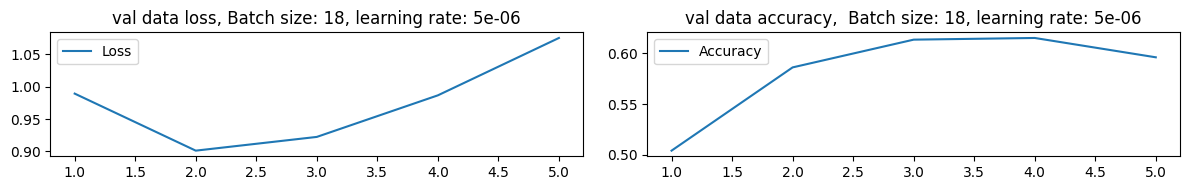

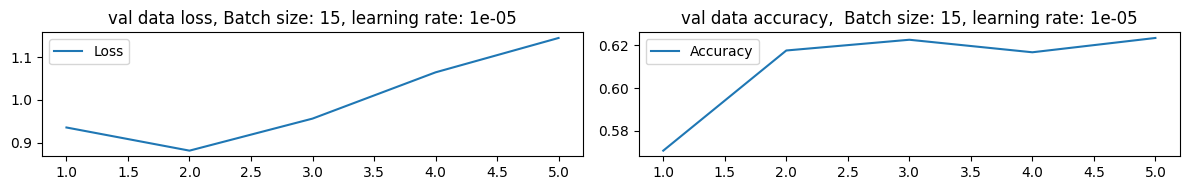

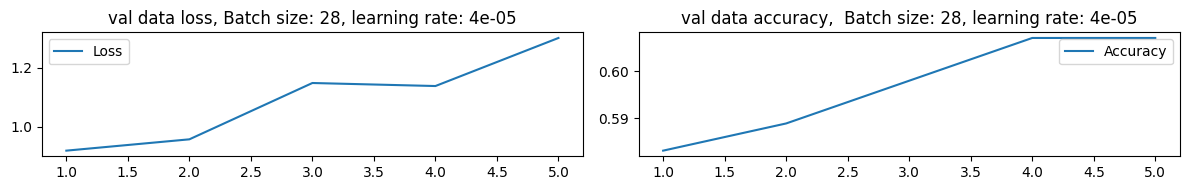

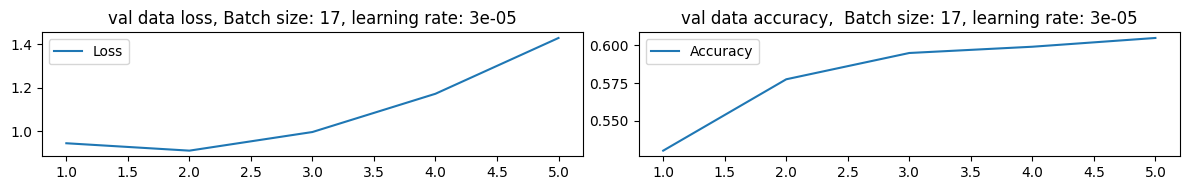

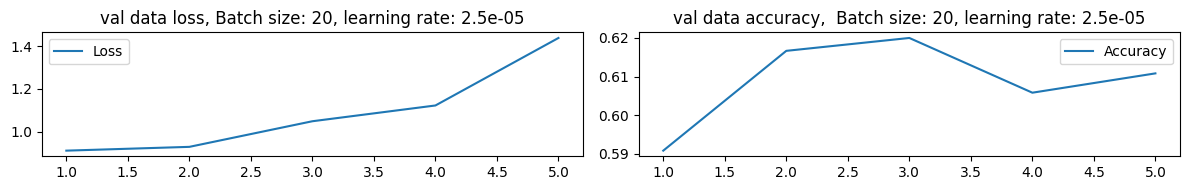

In [ ]:
index = 0
best_accuracy = 0
best_batch = 0
best_learning_rate = 0
best_model = None

for i in histories:
  history_dict = i.history
  loss = history_dict["val_loss"]
  acc = history_dict["val_accuracy"]
  figure, (ax1, ax2) = plt.subplots(1, 2, figsize= (12, 2))
  ax1.plot(numpy.arange(1,len(loss)+1), loss, label="Loss")
  ax1.set_title("val data loss, Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax1.legend()
  ax2.plot(numpy.arange(1,len(acc)+1), acc, label="Accuracy")
  ax2.set_title("val data accuracy,  Batch size: "+str(batches_used[index])+", learning rate: "+str(learning_rates_used[index]))
  ax2.legend()
  figure.tight_layout()
  index = index + 1
  if acc[-1] > best_accuracy:
    best_accuracy = acc[-1]
    best_batch = batches_used[index]
    best_learning_rate = learning_rates_used[index]
    best_model = models[index]

print("Best batch: "+str(best_batch))
print("Best learning rate: "+str(best_learning_rate))
print("Accuracy: "+str(best_accuracy))

In [ ]:
# Note that only the classifier requires the weights to be saved.
# No training is being done on the tokenizer or preprocessor since we are interested in pretraining the classifier.
dir_path = "Models/BERT"
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

best_model.save_weights("Models/BERT/Tuned_BERT_Multi.weights.h5")
